In [1]:
import numpy as np
import pandas as pd
import fiona
from shapely.geometry import shape, mapping
from GISio import shp2df, df2shp
import shapefile as sf

### read in a shapefile using `fiona`
more info here: https://github.com/Toblerity/Fiona  
`fiona` manual: http://toblerity.org/shapely/manual.html

In [2]:
with fiona.open('data/YaharaLakes.shp') as src:
    meta = src.meta
    records = []
    for line in src:
        props = line['properties']
        props['geometry'] = line.get('geometry', None)
        records.append(props)

In [3]:
src.meta

{'crs': {'init': 'epsg:4269'},
 'crs_wkt': 'GEOGCS["GCS_North_American_1983",DATUM["North_American_Datum_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295],AUTHORITY["EPSG","4269"]]',
 'driver': 'ESRI Shapefile',
 'schema': {'geometry': 'Polygon',
  'properties': OrderedDict([('COMID', 'int:9'),
               ('FDATE', 'date'),
               ('RESOLUTION', 'str:7'),
               ('GNIS_ID', 'str:10'),
               ('GNIS_NAME', 'str:65'),
               ('AREASQKM', 'float:19.11'),
               ('ELEVATION', 'float:19.11'),
               ('REACHCODE', 'str:14'),
               ('FTYPE', 'str:24'),
               ('FCODE', 'int:9'),
               ('SHAPE_LENG', 'float:19.11'),
               ('SHAPE_AREA', 'float:19.11')])}}

#### Each record is a dictionary similar to the GeoJSON format

In [4]:
records[0]

OrderedDict([('COMID', 13293316),
             ('FDATE', '1999-10-29'),
             ('RESOLUTION', 'Medium'),
             ('GNIS_ID', None),
             ('GNIS_NAME', None),
             ('AREASQKM', 0.631),
             ('ELEVATION', 0.0),
             ('REACHCODE', '07090002008508'),
             ('FTYPE', 'LakePond'),
             ('FCODE', 39004),
             ('SHAPE_LENG', 0.04133193759),
             ('SHAPE_AREA', 6.971186e-05),
             ('geometry',
              {'coordinates': [[(-89.38954830502291, 43.063793399823055, 0.0),
                 (-89.38945470502301, 43.063564733156795, 0.0),
                 (-89.38936110502317, 43.063473333156935, 0.0),
                 (-89.3892987050233, 43.06331333315717, 0.0),
                 (-89.38855010502442, 43.06251333315839, 0.0),
                 (-89.38848777169119, 43.06242179982519, 0.0),
                 (-89.38789530502544, 43.06187319982604, 0.0),
                 (-89.38789517169215, 43.061324533160246, 0.0),
        

### Make a `DataFrame` of the records
* information on the geometric features is stored in a `'geometry'` column but is still in GeoJSON-style format
* convert geometries to `shapely` features so we can do stuff with them

In [5]:
df = pd.DataFrame(records)
df['geometry'] = [shape(g) for g in df.geometry]
df.head()

,COMID,FDATE,RESOLUTION,GNIS_ID,GNIS_NAME,AREASQKM,ELEVATION,REACHCODE,FTYPE,FCODE,SHAPE_LENG,SHAPE_AREA,geometry
0,13293316,1999-10-29,Medium,None,None,0.631,0.0,07090002008508,LakePond,39004,0.041332,0.000070,POLYGON Z ((-89.38954830502291 43.063793399823...
1,167120949,2009-05-01,Medium,1793470,Lake Waubesa,22.376,258.0,07090002008652,LakePond,39009,0.448525,0.002472,POLYGON Z ((-89.32340237179221 43.040556333192...
2,167120948,2009-05-01,Medium,None,None,0.897,0.0,07090002008651,LakePond,39004,0.092017,0.000099,POLYGON Z ((-89.30433197182185 43.008721933241...
3,13293262,2009-05-01,Medium,1792750,Lake Mendota 254,39.804,259.0,07090002008466,LakePond,39009,0.443651,0.004401,POLYGON Z ((-89.40247037166949 43.150595533021...
4,13293322,2009-05-01,Medium,1793486,Lake Wingra 6,1.394,0.0,07090002008516,LakePond,39004,0.080127,0.000154,POLYGON Z ((-89.40457337166623 43.056679999834...


### inspect an individual feature

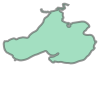

In [6]:
lake_mendota = df.geometry[3]
lake_mendota

In [7]:
lake_mendota.bounds

(-89.48365450487682, 43.077119533135715, -89.36740750505726, 43.15203419968611)

### since the geometries are `shapely` objects, there are many things we can do with them

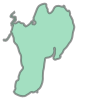

In [8]:
from shapely.affinity import rotate
rotate(lake_mendota, 60.)

### Read in the same shapefile with a filter
* this can speed up reading from large datasets (such as NHDPlus) if only a subset of the features are needed

In [9]:
with fiona.open('data/YaharaLakes.shp') as src:
    meta = src.meta
    records = []
    for line in src.filter(bbox=(-89.48, 43.1, -89.37, 43.15)):
        props = line['properties']
        props['geometry'] = line.get('geometry', None)
        records.append(props)
    df2 = pd.DataFrame(records)
df2.head()

,COMID,FDATE,RESOLUTION,GNIS_ID,GNIS_NAME,AREASQKM,ELEVATION,REACHCODE,FTYPE,FCODE,SHAPE_LENG,SHAPE_AREA,geometry
0,13293262,2009-05-01,Medium,1792750,Lake Mendota 254,39.804,259.0,07090002008466,LakePond,39009,0.443651,0.004401,"{'type': 'Polygon', 'coordinates': [[(-89.4024..."


### Use `GIS_utils`
* `shp2df` is a macro around `fiona` and `shapely` that also handles null geometries, dbf files, boolean values, etc.

In [10]:
df = shp2df('data/YaharaLakes.shp')
df


reading data/YaharaLakes.shp...
--> building dataframe... (may take a while for large shapefiles)


,COMID,FDATE,RESOLUTION,GNIS_ID,GNIS_NAME,AREASQKM,ELEVATION,REACHCODE,FTYPE,FCODE,SHAPE_LENG,SHAPE_AREA,geometry
0,13293316,1999-10-29,Medium,None,None,0.631,0.0,07090002008508,LakePond,39004,0.041332,0.000070,POLYGON Z ((-89.38954830502291 43.063793399823...
1,167120949,2009-05-01,Medium,1793470,Lake Waubesa,22.376,258.0,07090002008652,LakePond,39009,0.448525,0.002472,POLYGON Z ((-89.32340237179221 43.040556333192...
2,167120948,2009-05-01,Medium,None,None,0.897,0.0,07090002008651,LakePond,39004,0.092017,0.000099,POLYGON Z ((-89.30433197182185 43.008721933241...
3,13293262,2009-05-01,Medium,1792750,Lake Mendota 254,39.804,259.0,07090002008466,LakePond,39009,0.443651,0.004401,POLYGON Z ((-89.40247037166949 43.150595533021...
4,13293322,2009-05-01,Medium,1793486,Lake Wingra 6,1.394,0.0,07090002008516,LakePond,39004,0.080127,0.000154,POLYGON Z ((-89.40457337166623 43.056679999834...
5,13296360,2009-05-01,Medium,1793496,Lake Kegonsa 410,12.934,257.0,07090002008548,LakePond,39009,0.171238,0.001427,POLYGON Z ((-89.26181257188784 42.982753199948...


### Writing a `DataFrame` to a shapefile

#### make a schema
* since what we are writing out has the same structure as what we read in, we can recycle the schema. Otherwise, we'd have to make one.

In [11]:
src.meta['schema']

{'geometry': 'Polygon',
 'properties': OrderedDict([('COMID', 'int:9'),
              ('FDATE', 'date'),
              ('RESOLUTION', 'str:7'),
              ('GNIS_ID', 'str:10'),
              ('GNIS_NAME', 'str:65'),
              ('AREASQKM', 'float:19.11'),
              ('ELEVATION', 'float:19.11'),
              ('REACHCODE', 'str:14'),
              ('FTYPE', 'str:24'),
              ('FCODE', 'int:9'),
              ('SHAPE_LENG', 'float:19.11'),
              ('SHAPE_AREA', 'float:19.11')])}

#### define the coordinate system (if you want a .prj file)
* we can also recycle this
* but this can also be easily made if the [**epsg code**](http://www.epsg.org/) is known

In [12]:
src.meta['crs']

{'init': 'epsg:4269'}

In [13]:
from fiona.crs import from_epsg
from_epsg(4269)

{'init': 'epsg:4269', 'no_defs': True}

#### convert the `DataFrame` back to a dictionary

In [14]:
props = df.drop('geometry', axis=1).astype(object).to_dict(orient='records')
props[0]

{'AREASQKM': 0.631,
 'COMID': 13293316,
 'ELEVATION': 0.0,
 'FCODE': 39004,
 'FDATE': '1999-10-29',
 'FTYPE': 'LakePond',
 'GNIS_ID': None,
 'GNIS_NAME': None,
 'REACHCODE': '07090002008508',
 'RESOLUTION': 'Medium',
 'SHAPE_AREA': 6.971186e-05,
 'SHAPE_LENG': 0.04133193759}

#### `shapely.geometry.mapping` converts the `shapely` objects back to GeoJSON

In [15]:
mapped = [mapping(g) for g in df.geometry]
mapped[0]

{'coordinates': (((-89.38954830502291, 43.063793399823055, 0.0),
   (-89.38945470502301, 43.063564733156795, 0.0),
   (-89.38936110502317, 43.063473333156935, 0.0),
   (-89.3892987050233, 43.06331333315717, 0.0),
   (-89.38855010502442, 43.06251333315839, 0.0),
   (-89.38848777169119, 43.06242179982519, 0.0),
   (-89.38789530502544, 43.06187319982604, 0.0),
   (-89.38789517169215, 43.061324533160246, 0.0),
   (-89.38801990502526, 43.06105013316068, 0.0),
   (-89.38801977169192, 43.060661533161294, 0.0),
   (-89.3878949716921, 43.060547133161435, 0.0),
   (-89.3873961716929, 43.060615799827985, 0.0),
   (-89.3873027050264, 43.060821599827705, 0.0),
   (-89.38705317169342, 43.060821599827705, 0.0),
   (-89.38695970502692, 43.0607529998278, 0.0),
   (-89.38677250502718, 43.06057019982808, 0.0),
   (-89.3865231050276, 43.060272999828555, 0.0),
   (-89.38583697169531, 43.05956439982964, 0.0),
   (-89.38527570502953, 43.058878599830734, 0.0),
   (-89.38508857169649, 43.058695799831014, 0.0),

In [16]:
with fiona.collection('data/YaharaLakes2.shp', "w", driver="ESRI Shapefile", 
                      crs=src.meta['crs'], schema=src.meta['schema']) as output:
    for i in range(len(props)):
        output.write({'properties': props[i],
                      'geometry': mapped[i]})

### Using `GIS_utils`
* the `df2shp` macro uses `fiona` to write a `DataFrame` to a shapefile, taking care of the schem, coordinate system, and formatting

In [17]:
df2shp(df, 'data/YaharaLakes2.shp', epsg=4269)

writing data/YaharaLakes2.shp...


### `Pyshp` is an alternative to `fiona` that is written in pure python (`fiona` uses the OGR library)
* does not handle coordinate system defintions (no prj files)  
* also does not read dbf files for some reason

In [18]:
src = sf.Reader('data/YaharaLakes.shp')
src.fields

[('DeletionFlag', 'C', 1, 0),
 ['COMID', 'N', 9, 0],
 ['FDATE', 'D', 8, 0],
 ['RESOLUTION', 'C', 7, 0],
 ['GNIS_ID', 'C', 10, 0],
 ['GNIS_NAME', 'C', 65, 0],
 ['AREASQKM', 'N', 19, 11],
 ['ELEVATION', 'N', 19, 11],
 ['REACHCODE', 'C', 14, 0],
 ['FTYPE', 'C', 24, 0],
 ['FCODE', 'N', 9, 0],
 ['SHAPE_LENG', 'N', 19, 11],
 ['SHAPE_AREA', 'N', 19, 11]]

In [19]:
geoms = [shape(s) for s in src.iterShapes()]
records = [tuple(r) + (geoms[i],) for i, r in enumerate(src.iterRecords())]
records[0]

(13293316,
 '19991029',
 'Medium',
 b'          ',
 b'                                                                 ',
 0.631,
 0.0,
 '07090002008508',
 'LakePond',
 39004,
 0.04133193759,
 6.971186e-05,
 <shapely.geometry.polygon.Polygon at 0x1230764e0>)

In [20]:
src.fields

[('DeletionFlag', 'C', 1, 0),
 ['COMID', 'N', 9, 0],
 ['FDATE', 'D', 8, 0],
 ['RESOLUTION', 'C', 7, 0],
 ['GNIS_ID', 'C', 10, 0],
 ['GNIS_NAME', 'C', 65, 0],
 ['AREASQKM', 'N', 19, 11],
 ['ELEVATION', 'N', 19, 11],
 ['REACHCODE', 'C', 14, 0],
 ['FTYPE', 'C', 24, 0],
 ['FCODE', 'N', 9, 0],
 ['SHAPE_LENG', 'N', 19, 11],
 ['SHAPE_AREA', 'N', 19, 11]]

In [21]:
columns = [f[0] for f in src.fields[1:]] + ['geometry'] # discard the DeletionFlag field (not in records)
df = pd.DataFrame(records, columns=columns)
df.head()

,COMID,FDATE,RESOLUTION,GNIS_ID,GNIS_NAME,AREASQKM,ELEVATION,REACHCODE,FTYPE,FCODE,SHAPE_LENG,SHAPE_AREA,geometry
0,13293316,19991029,Medium,b' ',b' ...,0.631,0.0,07090002008508,LakePond,39004,0.041332,0.000070,POLYGON ((-89.38954830502291 43.06379339982306...
1,167120949,20090501,Medium,1793470,Lake Waubesa,22.376,258.0,07090002008652,LakePond,39009,0.448525,0.002472,POLYGON ((-89.32340237179221 43.04055633319246...
2,167120948,20090501,Medium,b' ',b' ...,0.897,0.0,07090002008651,LakePond,39004,0.092017,0.000099,POLYGON ((-89.30433197182185 43.00872193324187...
3,13293262,20090501,Medium,1792750,Lake Mendota 254,39.804,259.0,07090002008466,LakePond,39009,0.443651,0.004401,POLYGON ((-89.40247037166949 43.15059553302166...
4,13293322,20090501,Medium,1793486,Lake Wingra 6,1.394,0.0,07090002008516,LakePond,39004,0.080127,0.000154,"POLYGON ((-89.40457337166623 43.0566799998341,..."


### Writing with `pyshp`

#### specify the shape type
see https://en.wikipedia.org/wiki/Shapefile (scroll down to Shape Types table)
* get the shape type from a feature in the `geometry` column (we're assuming that they are all the same type, as required by the shapefile format)

In [22]:
types = {'Polygon': 5,
         'LineString': 3,
         'Point': 1}
geomtype = types[df.geometry[0].type]
geomtype

5

#### instantiate the shapefile writer

In [23]:
w = sf.Writer(geomtype)
w.autoBalance = 1 # prevents mismatch between number of features and records

#### rename the fields if necessary to enforce the 10-character limit

In [24]:
def enforce_10ch_limit(names):
    """Enforce 10 character limit for fieldnames.
    Add suffix for duplicate names starting at 0.

    Parameters
    ----------
    names : list of strings

    Returns
    -------
    names : list of unique strings of len <= 10.
    """
    names = [n[:9]+'1' if len(n) > 10 else n
             for n in names]
    dups = {x:names.count(x) for x in names}
    suffix = {n: list(range(len(cnt))) for n, cnt in dups.items() if cnt > 1}
    for i, n in enumerate(names):
        if dups[n] > 1:
            names[i] = n[:9] + str(suffix[n].pop(0))
    return names

# version of the dataframe without the geometry column
dfr = df.drop('geometry', axis=1)

names = enforce_10ch_limit(dfr.columns)
names

['COMID',
 'FDATE',
 'RESOLUTION',
 'GNIS_ID',
 'GNIS_NAME',
 'AREASQKM',
 'ELEVATION',
 'REACHCODE',
 'FTYPE',
 'FCODE',
 'SHAPE_LENG',
 'SHAPE_AREA']

#### Specify dtypes and write the fields

In [25]:
def get_pyshp_field_info(dtypename):
    """Get pyshp dtype information for a given numpy dtype."""
    fields = {'int': ('N', 20, 0),
              '<i': ('N', 20, 0),
              'float': ('F', 20, 12),
              '<f': ('F', 20, 0),
              'bool': ('L', 1),
              'b1': ('L', 1),
              'str': ('C', 50),
              'object': ('C', 50)}
    k = [k for k in fields.keys() if k in dtypename.lower()]
    if len(k) == 1:
        return fields[k[0]]
    else:
        return fields['str']

In [26]:
for i, npdtype in enumerate(dfr.dtypes):
    w.field(names[i], *get_pyshp_field_info(npdtype.name))

#### write out the features and records, handling the different shapetypes

In [27]:
g = df.geometry[0]
mapping(g)['coordinates']

(((-89.38954830502291, 43.063793399823055),
  (-89.38945470502301, 43.063564733156795),
  (-89.38936110502317, 43.063473333156935),
  (-89.3892987050233, 43.06331333315717),
  (-89.38855010502442, 43.06251333315839),
  (-89.38848777169119, 43.06242179982519),
  (-89.38789530502544, 43.06187319982604),
  (-89.38789517169215, 43.061324533160246),
  (-89.38801990502526, 43.06105013316068),
  (-89.38801977169192, 43.060661533161294),
  (-89.3878949716921, 43.060547133161435),
  (-89.3873961716929, 43.060615799827985),
  (-89.3873027050264, 43.060821599827705),
  (-89.38705317169342, 43.060821599827705),
  (-89.38695970502692, 43.0607529998278),
  (-89.38677250502718, 43.06057019982808),
  (-89.3865231050276, 43.060272999828555),
  (-89.38583697169531, 43.05956439982964),
  (-89.38527570502953, 43.058878599830734),
  (-89.38508857169649, 43.058695799831014),
  (-89.38508850502984, 43.058489999831295),
  (-89.38599257169506, 43.058421399831445),
  (-89.38755150502601, 43.05842113316476),
  (

In [28]:
geoms = df.geometry.tolist()
props = dfr.astype(object).values

In [29]:
# write the geometry and attributes for each record
if geomtype == 5:
    for i, r in enumerate(props):
        w.poly(mapping(geoms[i])['coordinates'])
        w.record(*r)
elif geomtype == 3:
    for i, r in enumerate(props):
        w.line(mapping(geoms[i])['coordinates'])
        w.record(*r)
elif geomtype == 1:
    for i, r in enumerate(props):
        w.point((mapping(geoms[i])['coordinates']))
        w.record(*r)
w.save('data/YaharaLakes2.shp')